In [2]:
# Installer les bibliothèques nécessaires (à exécuter une seule fois)
!pip install tensorflow pandas numpy matplotlib seaborn

# Importer les bibliothèques
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_error


In [3]:
# Fonction pour charger les fichiers de données
def load_data(file_path):
    """Charge les données depuis un fichier texte et les renvoie sous forme de DataFrame."""
    column_names = [
        'unit_number', 'time_in_cycles', 'operational_setting_1', 'operational_setting_2', 
        'operational_setting_3', 'sensor_measurement_1', 'sensor_measurement_2',
        'sensor_measurement_3', 'sensor_measurement_4', 'sensor_measurement_5',
        # Ajoutez les noms de colonnes pour tous les capteurs disponibles dans votre dataset
    ]
    return pd.read_csv(file_path, sep=" ", header=None, names=column_names, engine="python").dropna(axis=1)

# Chemins vers les fichiers
train_path = "C:\\Users\\no-one\\Desktop\\3éme ISI\\modele\\train_FD001.txt"
test_path = "C:\\Users\\no-one\\Desktop\\3éme ISI\\modele\\test_FD001.txt"
rul_path = "C:\\Users\\no-one\\Desktop\\3éme ISI\\modele\\RUL_FD001.txt"

# Charger les données
train_data = load_data(train_path)
test_data = load_data(test_path)
rul_data = pd.read_csv(rul_path, sep=" ", header=None)


Dimensions des données d'entraînement : (20631, 8)
Dimensions des données de test : (13096, 8)
        unit_number  time_in_cycles  operational_setting_1  \
count  20631.000000    20631.000000           2.063100e+04   
mean    8143.752722        8.442146           3.000000e-02   
std       19.076176        0.037505           1.556432e-14   
min     8099.940000        8.324900           3.000000e-02   
25%     8133.245000        8.414900           3.000000e-02   
50%     8140.540000        8.438900           3.000000e-02   
75%     8148.310000        8.465600           3.000000e-02   
max     8293.720000        8.584800           3.000000e-02   

       operational_setting_2  operational_setting_3  sensor_measurement_1  \
count           20631.000000                20631.0               20631.0   
mean              393.210654                 2388.0                 100.0   
std                 1.548763                    0.0                   0.0   
min               388.000000          

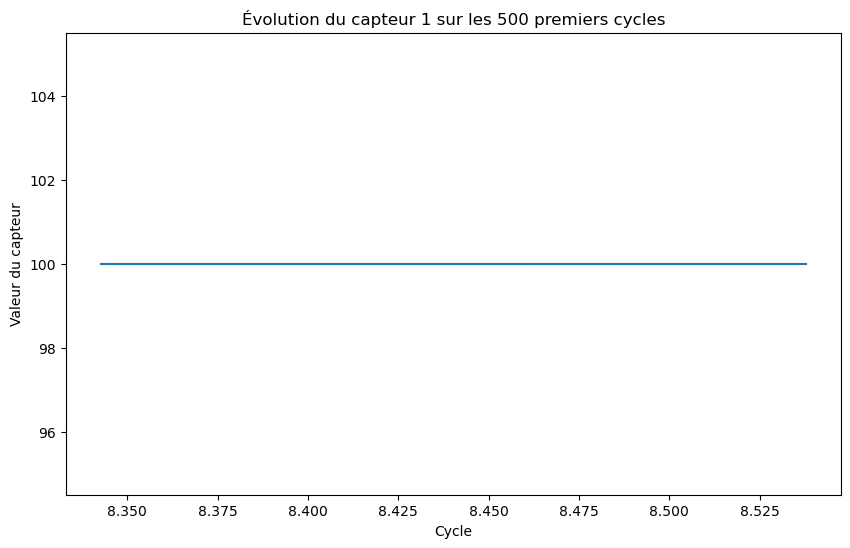

In [4]:
# Dimensions des datasets
print("Dimensions des données d'entraînement :", train_data.shape)
print("Dimensions des données de test :", test_data.shape)

# Afficher les statistiques descriptives
print(train_data.describe())

# Visualiser les capteurs
plt.figure(figsize=(10, 6))
sns.lineplot(data=train_data.iloc[:500], x='time_in_cycles', y='sensor_measurement_1')
plt.title('Évolution du capteur 1 sur les 500 premiers cycles')
plt.xlabel('Cycle')
plt.ylabel('Valeur du capteur')
plt.show()


In [5]:
!pip install tensorflow pandas numpy matplotlib seaborn


In [6]:
# Tester une simple cellule Python
print("Si vous voyez ce message, le kernel fonctionne.")


Si vous voyez ce message, le kernel fonctionne.


In [7]:
train_data['RUL'] = train_data.groupby('unit_number')['time_in_cycles'].transform("max") - train_data['time_in_cycles']


In [8]:
# Ajouter la RUL (Remaining Useful Life) aux données d'entraînement
train_data['RUL'] = train_data.groupby('unit_number')['time_in_cycles'].transform("max") - train_data['time_in_cycles']
print("Données d'entraînement avec RUL :")
print(train_data.head())

# Normalisation des capteurs
scaler = MinMaxScaler()
sensor_columns = [col for col in train_data.columns if 'sensor_measurement' in col]
train_data[sensor_columns] = scaler.fit_transform(train_data[sensor_columns])
print("Données normalisées (Entraînement) :")
print(train_data[sensor_columns].head())
print("\nDonnées normalisées (Test) :")
print(test_data[sensor_columns].head())

# Création des séquences pour le modèle LSTM
def create_sequences(data, seq_length, target_column):
    """Crée des séquences de longueur seq_length pour le LSTM."""
    sequences = []
    labels = []
    for unit in data['unit_number'].unique():
        unit_data = data[data['unit_number'] == unit]
        for i in range(len(unit_data) - seq_length):
            seq = unit_data.iloc[i:i+seq_length][sensor_columns].values
            label = unit_data.iloc[i+seq_length][target_column]
            sequences.append(seq)
            labels.append(label)
    return np.array(sequences), np.array(labels)

sequence_length = 50
X_train, y_train = create_sequences(train_data, sequence_length, target_column='RUL')
print("Données normalisées (Entraînement) :")
print(train_data[sensor_columns].head())
print("\nDonnées normalisées (Test) :")
print(test_data[sensor_columns].head())



Données d'entraînement avec RUL :
                                                                                                                     unit_number  \
1 1 -0.0007 -0.0004 100.0 518.67 641.82 1589.70 1400.60 14.62 21.61 554.36 2388.06 9046.19 1.3 47.47 521.66 2388.02      8138.62   
  2  0.0019 -0.0003 100.0 518.67 642.15 1591.82 1403.14 14.62 21.61 553.75 2388.04 9044.07 1.3 47.49 522.28 2388.07      8131.49   
  3 -0.0043  0.0003 100.0 518.67 642.35 1587.99 1404.20 14.62 21.61 554.26 2388.08 9052.94 1.3 47.27 522.42 2388.03      8133.23   
  4  0.0007  0.0000 100.0 518.67 642.35 1582.79 1401.87 14.62 21.61 554.45 2388.11 9049.48 1.3 47.13 522.86 2388.08      8133.83   
  5 -0.0019 -0.0002 100.0 518.67 642.37 1582.85 1406.22 14.62 21.61 554.00 2388.06 9055.15 1.3 47.28 522.19 2388.04      8133.80   

                                                                                                                     time_in_cycles  \
1 1 -0.0007 -0.0004 100.0 518.67 641.8

In [9]:
print(f"Taille de X_train : {X_train.shape}")
print(f"Taille de y_train : {y_train.shape}")



Taille de X_train : (0,)
Taille de y_train : (0,)


In [10]:
# Vérifier les séquences
print(f"Nombre de séquences générées pour X_train : {len(X_train)}")
print(f"Exemple d'une séquence dans X_train : {X_train[0] if len(X_train) > 0 else 'Aucune séquence'}")


Nombre de séquences générées pour X_train : 0
Exemple d'une séquence dans X_train : Aucune séquence


In [11]:
def create_sequences(data, sequence_length, target_column):
    sequences = []
    targets = []
    for i in range(len(data) - sequence_length):
        seq = data.iloc[i:i + sequence_length].drop(target_column, axis=1).values
        target = data.iloc[i + sequence_length][target_column]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

# Appliquer la fonction
sequence_length = 50
X_train, y_train = create_sequences(train_data, sequence_length, 'RUL')

# Vérifier les séquences
print(f"Taille de X_train après création : {X_train.shape}")
print(f"Taille de y_train après création : {y_train.shape}")


Taille de X_train après création : (20581, 50, 8)
Taille de y_train après création : (20581,)


In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input

# Définir le modèle LSTM avec Input
model = Sequential()

# Définir l'entrée explicitement
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))  # Shape: (50, 8)

# Ajouter la couche LSTM
model.add(LSTM(128, activation='relu', return_sequences=False))

# Ajouter une couche Dropout pour régulariser
model.add(Dropout(0.2))

# Ajouter une couche Dense pour la sortie (régression)
model.add(Dense(1))

# Compiler le modèle
model.compile(optimizer='adam', loss='mse', metrics=['mae'])




Epoch 1/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 2/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 3/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 4/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 5/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 6/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 7/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 8/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 9/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 10/20
515/515 ━━━━━━━━

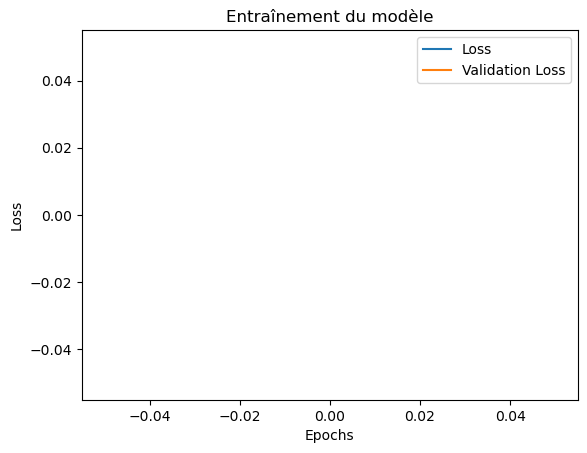

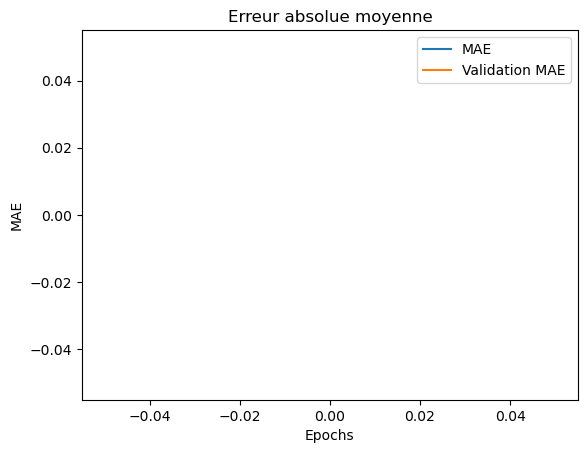

In [13]:
history = model.fit(X_train, y_train, validation_split=0.2, epochs=20, batch_size=32, verbose=1)

# Afficher l'historique de l'entraînement
import matplotlib.pyplot as plt

# Loss du modèle
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Entraînement du modèle')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Afficher la MAE (Mean Absolute Error)
plt.plot(history.history['mae'], label='MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Erreur absolue moyenne')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()


In [14]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

model = Sequential()

# Première couche LSTM avec dropout
model.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

# Deuxième couche LSTM
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))

# Couche Dense
model.add(Dense(units=32, activation='relu'))

# Couche de sortie
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])


C:\Users\no-one\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [15]:
from keras.callbacks import LearningRateScheduler

def scheduler(epoch, lr):
    if epoch % 10 == 0 and epoch != 0:
        lr = lr * 0.5
    return lr

lr_scheduler = LearningRateScheduler(scheduler)

history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, callbacks=[lr_scheduler])


Epoch 1/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 30s 48ms/step - loss: 0.0068 - mae: 0.0524 - val_loss: 0.0014 - val_mae: 0.0312 - learning_rate: 0.0010
Epoch 2/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 25s 48ms/step - loss: 0.0014 - mae: 0.0317 - val_loss: 0.0014 - val_mae: 0.0311 - learning_rate: 0.0010
Epoch 3/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 25s 48ms/step - loss: 0.0014 - mae: 0.0317 - val_loss: 0.0014 - val_mae: 0.0314 - learning_rate: 0.0010
Epoch 4/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - loss: 0.0014 - mae: 0.0314 - val_loss: 0.0014 - val_mae: 0.0312 - learning_rate: 0.0010
Epoch 5/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 23s 44ms/step - loss: 0.0014 - mae: 0.0315 - val_loss: 0.0014 - val_mae: 0.0312 - learning_rate: 0.0010
Epoch 6/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 26s 51ms/step - loss: 0.0014 - mae: 0.0314 - val_loss: 0.0014 - val_mae: 0.0312 - learning_rate: 0.0010
Epoch 7/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 28s 54ms/step - loss: 0.0014 - mae: 0.0312 - val_loss: 0.0014 - val_mae: 0.0312 - learning_rate:

In [16]:
from keras.regularizers import l2

model.add(Dense(units=32, activation='relu', kernel_regularizer=l2(0.01)))


In [17]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 57s 111ms/step - loss: 0.0014 - mae: 0.0312 - val_loss: 0.0014 - val_mae: 0.0311
Epoch 2/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 56s 108ms/step - loss: 0.0014 - mae: 0.0315 - val_loss: 0.0014 - val_mae: 0.0311
Epoch 3/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 54s 104ms/step - loss: 0.0014 - mae: 0.0311 - val_loss: 0.0014 - val_mae: 0.0313
Epoch 4/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 68s 77ms/step - loss: 0.0014 - mae: 0.0316 - val_loss: 0.0014 - val_mae: 0.0311
Epoch 5/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 39s 76ms/step - loss: 0.0014 - mae: 0.0313 - val_loss: 0.0014 - val_mae: 0.0311
Epoch 6/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 40s 77ms/step - loss: 0.0014 - mae: 0.0310 - val_loss: 0.0014 - val_mae: 0.0313
Epoch 7/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 48s 93ms/step - loss: 0.0014 - mae: 0.0315 - val_loss: 0.0014 - val_mae: 0.0311
Epoch 8/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 43s 83ms/step - loss: 0.0014 - mae: 0.0315 - val_loss: 0.0014 - val_mae: 0.0312
Epoch 9/100
515/515 ━━━━━━━━━

In [18]:
# Supposons que `train_data` est votre DataFrame d'entraînement
X = train_data.drop(columns=['unit_number', 'time_in_cycles', 'RUL'])  # Dropping non-numerical columns and target column
y = train_data['RUL']  # La colonne cible est 'RUL'

# Diviser les données en ensemble d'entraînement et ensemble de test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vérifier les tailles des ensembles
print(f"Taille de X_train : {X_train.shape}")
print(f"Taille de X_test : {X_test.shape}")
print(f"Taille de y_train : {y_train.shape}")
print(f"Taille de y_test : {y_test.shape}")



Taille de X_train : (16504, 6)
Taille de X_test : (4127, 6)
Taille de y_train : (16504,)
Taille de y_test : (4127,)


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Diviser les données en entrées (X) et sorties (y)
X = train_data.drop('RUL', axis=1).values  # Exclure la colonne 'RUL'
y = train_data['RUL'].values  # La colonne 'RUL' comme cible

# Diviser les données en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalisation des données
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Vérification de la forme des données
print(f"Taille de X_train_scaled : {X_train_scaled.shape}")
print(f"Taille de X_test_scaled : {X_test_scaled.shape}")


Taille de X_train_scaled : (16504, 8)
Taille de X_test_scaled : (4127, 8)


In [20]:
# Reshaper les données pour correspondre à l'entrée LSTM (samples, timesteps, features)
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Vérifier les nouvelles formes
print(f"Taille de X_train_scaled après reshape : {X_train_scaled.shape}")
print(f"Taille de X_test_scaled après reshape : {X_test_scaled.shape}")


Taille de X_train_scaled après reshape : (16504, 1, 8)
Taille de X_test_scaled après reshape : (4127, 1, 8)


In [21]:
y_test = y_test.squeeze()  # Convertir en forme (n_samples,)


In [22]:
model.add(Dense(1))


In [23]:
y_test = y_test.squeeze()  # Pour assurer que y_test est un vecteur 1D


In [24]:
model.add(LSTM(units=64, return_sequences=False))  # return_sequences=False pour une sortie 2D
model.add(Dense(1))  # Prédiction scalaire


In [25]:
y_train = y_train.squeeze()
y_test = y_test.squeeze()


In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input

# Définir un modèle LSTM
model = Sequential()

# Ajouter un Input explicite pour spécifier la forme d'entrée
model.add(Input(shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))

# Ajouter la couche LSTM sans spécifier 'input_shape'
model.add(LSTM(units=64, return_sequences=False))

# Ajouter une couche Dense pour la sortie
model.add(Dense(1))  # Une seule sortie

# Compilation du modèle
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])


In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input

# Définir un modèle LSTM
model = Sequential()

# Ajouter un Input explicite pour spécifier la forme d'entrée
model.add(Input(shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))

# Ajouter la couche LSTM sans spécifier 'input_shape'
model.add(LSTM(units=64, return_sequences=False))

# Ajouter une couche Dense pour la sortie
model.add(Dense(1))  # Une seule sortie

# Compilation du modèle
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])


In [28]:
test_loss, test_mae = model.evaluate(X_test_scaled, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")


129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0039 - mae: 0.0500
Test Loss: 0.003983176779001951
Test MAE: 0.050605982542037964


129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


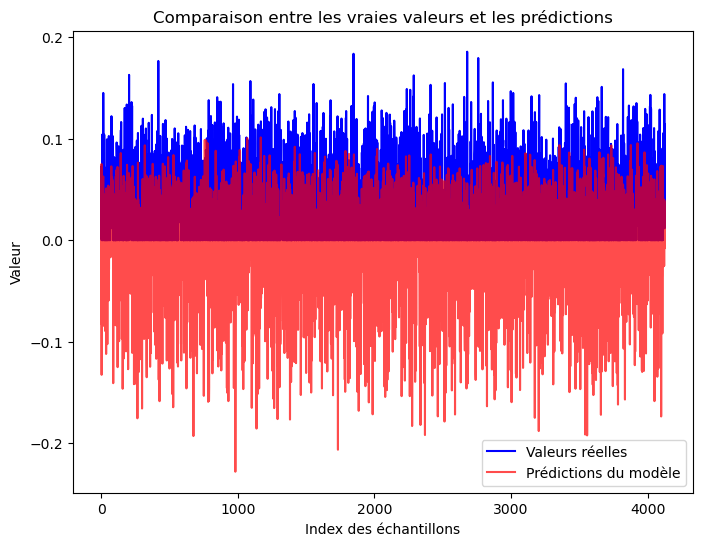

In [29]:
# Prédire les valeurs pour l'ensemble de test
y_pred = model.predict(X_test_scaled)

# Tracer les prédictions vs les vraies valeurs
plt.figure(figsize=(8, 6))
plt.plot(y_test, label='Valeurs réelles', color='blue')
plt.plot(y_pred, label='Prédictions du modèle', color='red', alpha=0.7)
plt.title('Comparaison entre les vraies valeurs et les prédictions')
plt.xlabel('Index des échantillons')
plt.ylabel('Valeur')
plt.legend()
plt.show()


129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


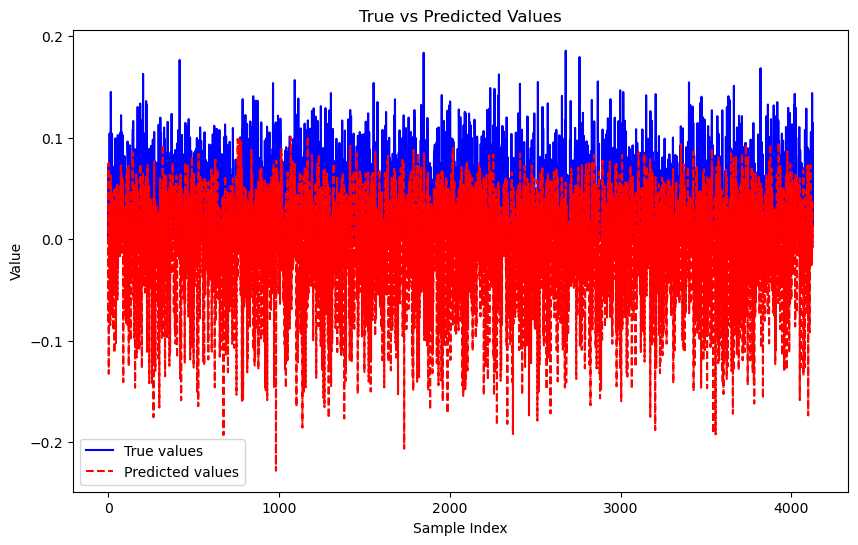

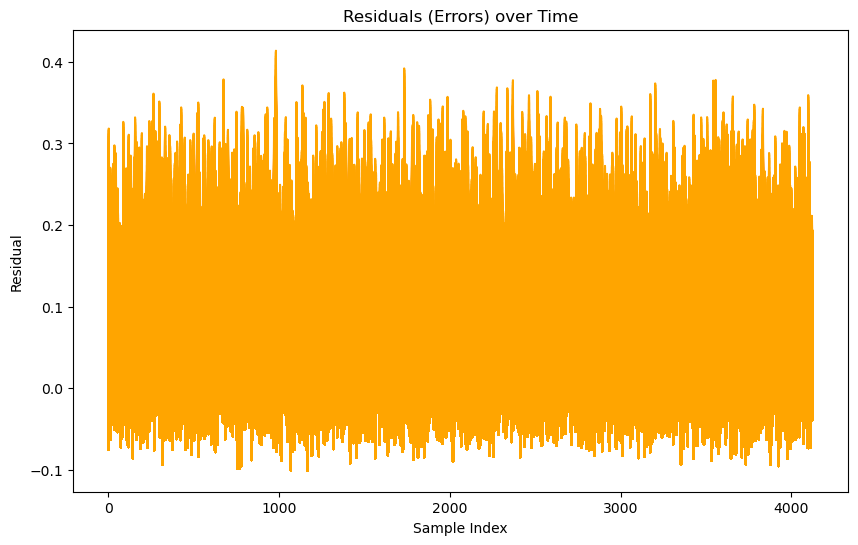

Mean of residuals: 0.044067287223157385
Standard deviation of residuals: 0.06408491331625106


In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Prédictions sur les données de test
y_pred = model.predict(X_test_scaled)

# Calcul des résidus (erreurs)
residuals = y_test - y_pred

# Visualisation des résidus
plt.figure(figsize=(10,6))
plt.plot(y_test, label="True values", color="blue")
plt.plot(y_pred, label="Predicted values", color="red", linestyle="--")
plt.title("True vs Predicted Values")
plt.xlabel("Sample Index")
plt.ylabel("Value")
plt.legend()
plt.show()

# Visualisation des erreurs (résidus)
plt.figure(figsize=(10,6))
plt.plot(residuals, color="orange")
plt.title("Residuals (Errors) over Time")
plt.xlabel("Sample Index")
plt.ylabel("Residual")
plt.show()

# Affichage des statistiques des erreurs
print(f"Mean of residuals: {np.mean(residuals)}")
print(f"Standard deviation of residuals: {np.std(residuals)}")


C:\Users\no-one\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - loss: 8.9099e-04 - mae: 0.0230 - val_loss: 6.7699e-04 - val_mae: 0.0205
Epoch 2/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.8631e-04 - mae: 0.0202 - val_loss: 6.5550e-04 - val_mae: 0.0195
Epoch 3/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.4658e-04 - mae: 0.0194 - val_loss: 6.6754e-04 - val_mae: 0.0199
Epoch 4/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.7035e-04 - mae: 0.0198 - val_loss: 6.9593e-04 - val_mae: 0.0195
Epoch 5/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.4704e-04 - mae: 0.0194 - val_loss: 6.4974e-04 - val_mae: 0.0194
Epoch 6/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.5410e-04 - mae: 0.0196 - val_loss: 6.4899e-04 - val_mae: 0.0196
Epoch 7/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.4729e-04 - mae: 0.0193 - val_loss: 6.5062e-04 - val_mae: 0.0194
Epoch 8/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.3839e-04 - mae: 0.0191 - val_loss: 6.4874e-04 - val_ma

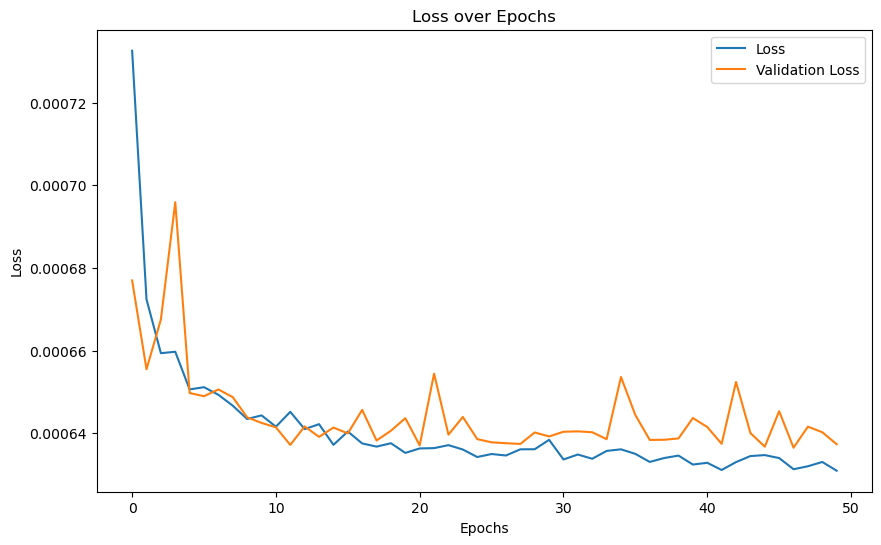

In [31]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split

# Diviser les données d'entraînement en un sous-ensemble d'entraînement et un sous-ensemble de validation
X_train_scaled, X_val_scaled, y_train, y_val = train_test_split(X_train_scaled, y_train, test_size=0.2, random_state=42)

# Maintenant, vous pouvez utiliser X_train_scaled et y_train pour l'entraînement,
# et X_val_scaled et y_val pour la validation


# Construction d'un nouveau modèle LSTM
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
model.add(Dropout(0.2))  # Ajout de Dropout pour régulariser le modèle
model.add(LSTM(units=32, return_sequences=False))
model.add(Dense(units=1))  # Prédiction d'une seule valeur (RUL)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Entraînement du modèle avec validation
history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=64, validation_data=(X_val_scaled, y_val))

# Résultats de l'entraînement
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [32]:
from sklearn.metrics import mean_absolute_error, r2_score

# Calcul des prédictions
y_pred = model.predict(X_test_scaled)

# Calcul de MAE et R2
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test MAE: {mae}")
print(f"Test R2: {r2}")


129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Test MAE: 0.019319621098833714
Test R2: 0.5394965549494324


In [33]:
import numpy as np
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.optimizers import Adam

# Supposons que X_train_scaled et y_train sont vos données d'entraînement prétraitées
# Par exemple, X_train_scaled est de forme (samples, time_steps, features)

# Définir le nombre de plis pour la validation croisée
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialiser les variables pour stocker les résultats
val_losses = []
val_maes = []

# Validation croisée
for train_index, val_index in kf.split(X_train_scaled):
    # Diviser les données en ensembles d'entraînement et de validation
    X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    # Construire le modèle
    model = Sequential()
    model.add(LSTM(units=64, return_sequences=True, input_shape=(X_train_fold.shape[1], X_train_fold.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(units=32))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))

    # Compiler le modèle
    model.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['mae'])

    # Entraîner le modèle
    model.fit(X_train_fold, y_train_fold, epochs=50, batch_size=64, validation_data=(X_val_fold, y_val_fold), verbose=0)

    # Évaluer le modèle sur l'ensemble de validation
    val_loss, val_mae = model.evaluate(X_val_fold, y_val_fold, verbose=0)

    # Ajouter les résultats pour ce pli
    val_losses.append(val_loss)
    val_maes.append(val_mae)

# Afficher les résultats de la validation croisée
print(f"Moyenne de la perte de validation : {np.mean(val_losses)}")
print(f"Moyenne de MAE de validation : {np.mean(val_maes)}")


C:\Users\no-one\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Moyenne de la perte de validation : 0.0006309889839030802
Moyenne de MAE de validation : 0.018839946389198302


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step


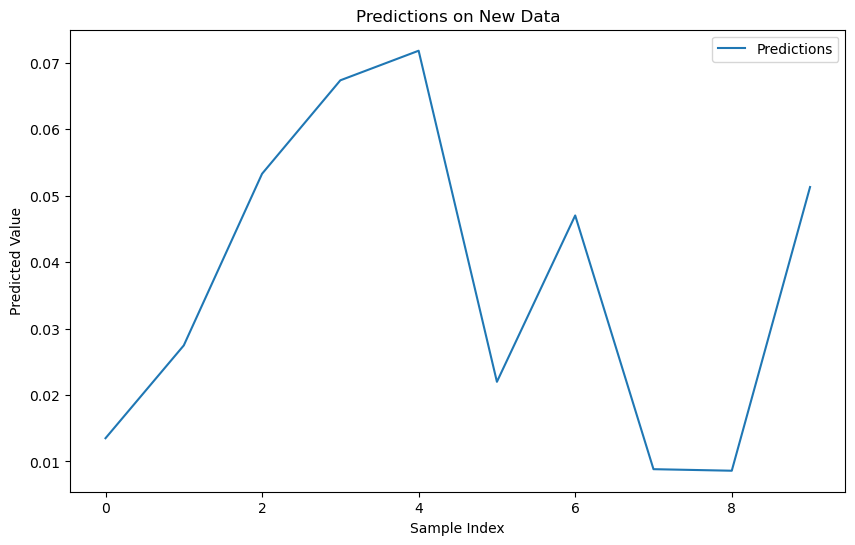

In [34]:
# Simulation des nouvelles données en production
new_data = np.random.randn(10, X_train_scaled.shape[1], X_train_scaled.shape[2])  # Exemple de nouvelles données
new_predictions = model.predict(new_data)

# Visualisation des prédictions en production
plt.figure(figsize=(10,6))
plt.plot(new_predictions, label="Predictions")
plt.title("Predictions on New Data")
plt.xlabel("Sample Index")
plt.ylabel("Predicted Value")
plt.legend()
plt.show()


In [35]:
# Sauvegarde du modèle au format natif Keras (.keras)
model.save('my_model.keras')


In [36]:
from keras.models import load_model
from keras.optimizers import Adam

# Charger le modèle
model = load_model('my_model.keras')

# Recompiler avec le même optimiseur utilisé pendant l'entraînement
model.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['mae'])


In [37]:
model = load_model('my_model.keras')
model.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['mae'])



In [38]:
# Fonction pour charger les fichiers de données
def load_data(file_path):
    """Charge les données depuis un fichier texte et les renvoie sous forme de DataFrame."""
    column_names = [
        'unit_number', 'time_in_cycles', 'operational_setting_1', 'operational_setting_2', 
        'operational_setting_3', 'sensor_measurement_1', 'sensor_measurement_2',
        'sensor_measurement_3', 'sensor_measurement_4', 'sensor_measurement_5',
        # Ajoutez les noms de colonnes pour tous les capteurs disponibles dans votre dataset
    ]
    return pd.read_csv(file_path, sep=" ", header=None, names=column_names, engine="python").dropna(axis=1)

# Chemins vers les fichiers
train_path = "C:\\Users\\no-one\\Desktop\\3éme ISI\\modele\\train_FD001.txt"
test_path = "C:\\Users\\no-one\\Desktop\\3éme ISI\\modele\\test_FD001.txt"
rul_path = "C:\\Users\\no-one\\Desktop\\3éme ISI\\modele\\RUL_FD001.txt"

# Charger les données
train_data = load_data(train_path)
test_data = load_data(test_path)
rul_data = pd.read_csv(rul_path, sep=" ", header=None)


In [39]:
import pandas as pd

# Calcul des caractéristiques supplémentaires
window_size = 5  # Taille de la fenêtre glissante

# Supposons que nous voulons appliquer les transformations sur 'sensor_measurement_1'
train_data['sensor_moving_avg'] = train_data['sensor_measurement_1'].rolling(window=window_size).mean()
train_data['sensor_rolling_std'] = train_data['sensor_measurement_1'].rolling(window=window_size).std()
train_data['sensor_derivative'] = train_data['sensor_measurement_1'].diff()
train_data['sensor_second_derivative'] = train_data['sensor_measurement_1'].diff().diff()
train_data['sensor_rolling_var'] = train_data['sensor_measurement_1'].rolling(window=window_size).var()
train_data['sensor_25th_percentile'] = train_data['sensor_measurement_1'].rolling(window=window_size).quantile(0.25)
train_data['sensor_75th_percentile'] = train_data['sensor_measurement_1'].rolling(window=window_size).quantile(0.75)

# Supprimer les NaN générés par les fenêtres glissantes
train_data = train_data.dropna()

# Vérifier le résultat après transformation
print(train_data.head())


                                                                                                                     unit_number  \
1 5 -0.0019 -0.0002 100.0 518.67 642.37 1582.85 1406.22 14.62 21.61 554.00 2388.06 9055.15 1.3 47.28 522.19 2388.04      8133.80   
  6 -0.0043 -0.0001 100.0 518.67 642.10 1584.47 1398.37 14.62 21.61 554.67 2388.02 9049.68 1.3 47.16 521.68 2388.03      8132.85   
  7  0.0010  0.0001 100.0 518.67 642.48 1592.32 1397.77 14.62 21.61 554.34 2388.02 9059.13 1.3 47.36 522.32 2388.03      8132.32   
  8 -0.0034  0.0003 100.0 518.67 642.56 1582.96 1400.97 14.62 21.61 553.85 2388.00 9040.80 1.3 47.24 522.47 2388.03      8131.07   
  9  0.0008  0.0001 100.0 518.67 642.12 1590.98 1394.80 14.62 21.61 553.69 2388.05 9046.46 1.3 47.29 521.79 2388.05      8125.69   

                                                                                                                     time_in_cycles  \
1 5 -0.0019 -0.0002 100.0 518.67 642.37 1582.85 1406.22 14.62 21.61 554.